In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = 2,
    c2 = 2,
    w = 1,
    w_decay = 1,
    scale_hyperparameter = False,
    regularizer = None,
    mask = False))

see one see two 2 2


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\Ai-lab\\github_repo\\neural-network\\', 'dataset')
GROUP = 3
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)

Checkpoint 100, Accuracy: 0.8765432098765432, Loss: 0.4807636826126664
Checkpoint 200, Accuracy: 0.8765432098765432, Loss: 0.4807636826126664
Checkpoint 300, Accuracy: 0.8765432098765432, Loss: 0.4807636826126664
Checkpoint 400, Accuracy: 0.8765432098765432, Loss: 0.4807636826126664
Checkpoint 500, Accuracy: 0.8765432098765432, Loss: 0.4807636826126664


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [12]:
train_acc = [h['accuracy'] for h in history]
train_mse = [h['mean_square_error'] for h in history]
train_cce = [h['categorical_crossentropy'] for h in history]

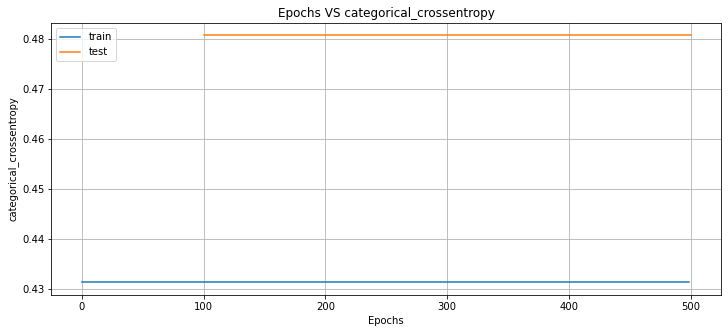

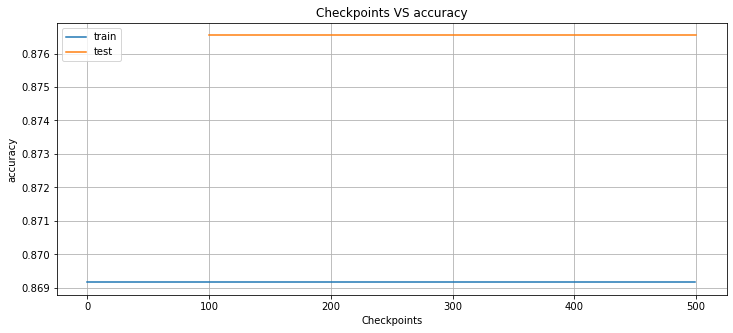

In [13]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_cce, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [train_acc, acc], x_label = 'Checkpoints', \
    y_label = 'accuracy', legend=['train', 'test'])

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[0. 0. 1.] <-> [0.24979635 0.00108043 0.7491233 ]
[1. 0. 0.] <-> [0.874257   0.04233622 0.0834068 ]
[0. 1. 0.] <-> [0.5681804  0.42360708 0.00821246]
[1. 0. 0.] <-> [0.7616401  0.0232048  0.21515512]
[0. 1. 0.] <-> [0.5510472  0.44664225 0.00231059]
[1. 0. 0.] <-> [0.7009393  0.01508408 0.28397664]
[0. 1. 0.] <-> [0.55970293 0.4361908  0.00410629]
[1. 0. 0.] <-> [0.7780667  0.04655478 0.17537856]
[1. 0. 0.] <-> [0.6032162  0.00667627 0.3901075 ]
[1. 0. 0.] <-> [0.64798963 0.015314   0.33669633]
[1. 0. 0.] <-> [0.83326316 0.15084958 0.0158872 ]
[1. 0. 0.] <-> [0.7092671  0.22456685 0.06616608]
[1. 0. 0.] <-> [0.87473935 0.07925193 0.04600867]
[0. 1. 0.] <-> [0.6870818  0.24080706 0.07211114]
[1. 0. 0.] <-> [0.86569285 0.10525755 0.02904958]
[0. 1. 0.] <-> [0.59892166 0.38620338 0.01487499]
[1. 0. 0.] <-> [0.7643981  0.03773572 0.19786617]
[0. 1. 0.] <-> [0.58029115 0.40591505 0.01379381]
[1. 0. 0.] <-> [0.81143516 0.0894868  0.09907797]
[1. 0. 0.] <-> [0.8975786  0.04119954 0.06122177]


In [14]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8765432098765432, 'mean_square_error': 0.2422485056426965, 'categorical_crossentropy': 0.4807636826126664, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 4}}, 'checkpoint': 100} 


{'accuracy': 0.8765432098765432, 'mean_square_error': 0.2422485056426965, 'categorical_crossentropy': 0.4807636826126664, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 93, 'fn_hit': 4}}, 'checkpoint': 200} 


{'accuracy': 0.8765432098765432, 'mean_square_error': 0.2422485056426965, 'categorical_crossentropy': 0.4807636826126664, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 19, 'tn_hit': 11, 'fn_hit': 0}, 1: {'tp_hit': 0, 'fp_hit': 0, 'tn_hit': 92, 'fn_hit': 16}, 2: {'tp_hit': 10, 'fp_hit': 1, 'tn_hit': 93, 'f

In [15]:
print(model)

Layer 1
Neuron 0: weights:
[-2.2902042  -1.93746811  0.63440183 -2.09584967 -1.62186664]
 bias: -1.4584670407577844

Neuron 1: weights:
[-2.52372973  1.88019085  0.23627536  1.35245596 -0.734946  ]
 bias: -0.4277200856975085

Neuron 2: weights:
[ 2.48133699  0.55947565 -0.27292809  0.96185392  0.6047081 ]
 bias: -2.9159526345364375

Neuron 3: weights:
[-0.76195106 -2.91325052 -1.65809164  2.13484851 -0.1232212 ]
 bias: -0.4487147298914058

$
Layer 2
Neuron 0: weights:
[ 1.71861675 -1.96165674  0.60117274 -0.78083546]
 bias: 1.266420374681604

Neuron 1: weights:
[ 1.94541964  1.00406119 -0.42056118 -2.14322041]
 bias: -2.131603938479281

Neuron 2: weights:
[-1.64893311 -2.74704215  2.11913529  0.72462506]
 bias: -0.12220131046936178

$

